In [1]:
import os
import tempfile
import torch
from pathlib import Path

from csv import writer
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from data_utils.csv_dataloader import create_csv_flowpic_loader
from models.configurable_cnn import ConfigurableCNN
from training.trainer import train_model
from training.utils import set_seed, save_config_to_json
from config import Config


In [2]:
apps_id_df = pd.read_csv('/home/anatbr/dataset/Allot/ver02 - Location 01 - 2024.09.12-17_AppIds G Z.csv', index_col=0)
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
num_classes = len(label_mapping)
cfg = Config(RESOLUTION=64)

In [3]:
cfg.MODEL_PARAMS['num_classes'] = num_classes
model = ConfigurableCNN(cfg.MODEL_PARAMS).to(cfg.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', 'chunk_000.csv')
train_loader = create_csv_flowpic_loader([train_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64)

In [4]:
test_chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{100:03d}.csv')
test_loader_1 = create_csv_flowpic_loader([test_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64, log_t_axis=False)
test_loader_2 = create_csv_flowpic_loader([test_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64, log_t_axis=True)

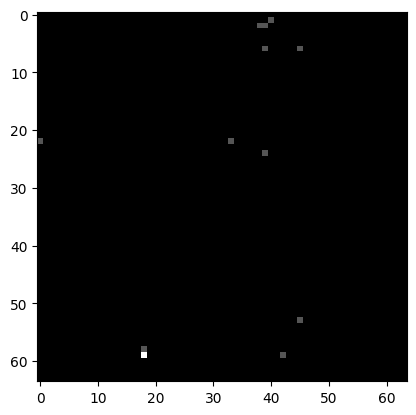

In [34]:
for x, y in test_loader_2:
    plt.imshow(x[np.random.randint(64)].cpu().numpy(), cmap='gray')
    break

In [15]:
train_df = pd.read_csv(train_chunk_path, index_col=0)
test_df = pd.read_csv(test_chunk_path, index_col=0)

In [ ]:
log_t_axis

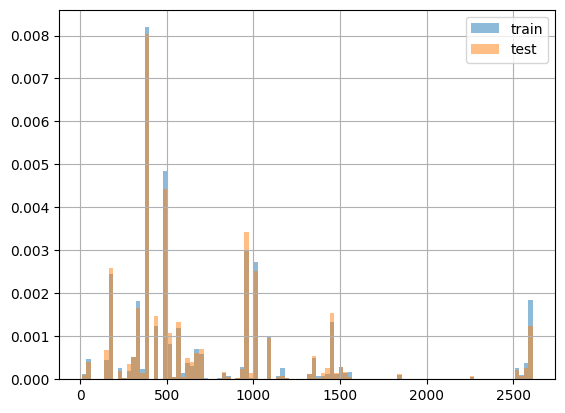

In [16]:
train_df.appId.hist(alpha=0.5, bins=100, density=True, label='train')
test_df.appId.hist(alpha=0.5, bins=100, density=True, label='test')
plt.legend()
plt.show()

In [ ]:
for i in range(0, 200, 100):
    experiment_path = cfg.EXPERIMENT_PATH / "000_to_{i:003d}"
    experiment_path.mkdir(parents=True, exist_ok=True)

    weights_save_dir = experiment_path / 'weights'
    plots_save_dir = experiment_path / 'plots'
    weights_save_dir.mkdir(parents=True, exist_ok=True)
    plots_save_dir.mkdir(parents=True, exist_ok=True)

    save_config_to_json(config_module=cfg, output_file_path=experiment_path / "config.json")
    
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{i:03d}.csv')
    test_loader = create_csv_flowpic_loader([chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64)

    train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=cfg.NUM_EPOCHS,
        device=cfg.DEVICE,
        weights_save_dir=weights_save_dir,
        plots_save_dir=plots_save_dir,
        label_mapping=label_mapping,
        lambda_mmd=cfg.LAMBDA_MMD,
        mmd_bandwidths=cfg.MMD_BANDWIDTHS,
        lambda_dann=cfg.LAMBDA_DANN,
    )

    final_model_path = weights_save_dir / f"model_final_001_to_{i:03d}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Model for train domain train_domain to test domain {i:03d} saved to {final_model_path}")


Epoch 0.0: GRL Lambda = 0.0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
import pandas as pd
pd.Series(labelss).value_counts().sort_values().iloc[40:69]

937     14
555     14
2596    15
2262    16
2536    16
1083    17
289     17
966     17
1142    18
1855    18
1437    19
665     20
1382    21
1389    21
522     21
320     22
305     22
700     22
8       25
506     25
239     28
159     29
1487    30
1356    32
272     32
1325    33
595     36
1527    37
219     39
Name: count, dtype: int64

In [4]:
sessions[0].sum()

tensor(10.)

In [5]:
loader.dataset.sessions[0]

([0, 3, 4, 4, 33, 36, 38, 38, 58, 63],
 [1250, 1250, 1250, 450, 1250, 163, 518, 121, 31, 24])

In [6]:
sessions.shape

torch.Size([1, 1, 64, 64])

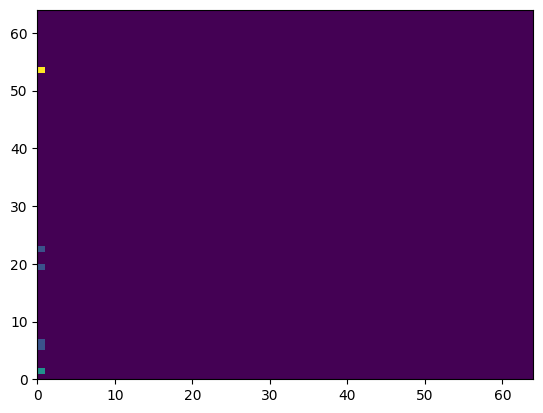

In [ ]:
import matplotlib.pyplot as plt